# LangGraph Example

In [1]:
!which python

/Users/Yam/miniconda3/bin/python


In [2]:
%pip install -U langgraph langsmith langchain_anthropic -i https://pypi.org/simple

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.140
    Uninstalling langsmith-0.1.140:
      Successfully uninstalled langsmith-0.1.140
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"] = "anything"
os.environ["OPENAI_API_KEY"] = "sk-uC9JmkqkNAfDbotnsJODyIabgr1w8djaC9MqtcV4GZaUlPsY"

## Basic Chatbot

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

- Every node will receive the current `State` as input and return a value that updates that state. 
- messages will be appended to the current list, with `add_messages`.

---

- 每个节点将接收当前状态作为输入，并返回一个更新该状态的值。
- 消息将被追加到当前列表中，使用 add_messages。

In [6]:
import os
from langchain_openai.chat_models.base import ChatOpenAI


llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)


# 仅支持 claude：https://docs.anthropic.com/en/docs/about-claude/models
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(
#     model="claude-3-5-sonnet-20240620"
# )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

- Current `State` as input and returns a dictionary containing an updated messages list under the key "messages".
- This is the basic pattern for all LangGraph node functions.

---

- 将当前的“State”作为输入，并返回一个包含在键“messages”下更新的消息列表的字典。
- 这是所有LangGraph节点函数的基本模式。

In [7]:
# add an entry point. This tells our graph where to start its work each time we run it.
# 添加入口，告诉图每次从哪儿开始执行
graph_builder.add_edge(START, "chatbot")

In [8]:
# set a finish point. This instructs the graph "any time this node is run, you can exit."
# 设置结束节点，告诉图，每次该节点执行后从这里退出
graph_builder.add_edge("chatbot", END)

In [9]:
# This creates a "CompiledGraph" we can use invoke on our state.
# 会创建一个编译后的图
graph = graph_builder.compile()

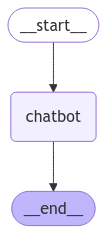

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

上面定义的其实就是一个LLM，只是把它作为一个节点放在了图上。

下面是简单示例：

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [12]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  你好


Assistant: 你好！很高兴为你服务。有什么问题我可以帮你解答吗？


User:  你是谁？


Assistant: 你好！我是一个人工智能助手，由 Moonshot AI 开发。我在这里帮助你回答问题，提供信息，并且我们可以用中文或英文进行交流。有什么可以帮你的吗？


User:  quit


Goodbye!


In [15]:
cb = graph.nodes["chatbot"]

## Tools

与上节类似，先定义工具。

In [16]:
from baiduserp_wapper import BaiduSearchAPIWrapper

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [18]:
search = TavilySearchResults(max_results=2)

search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

然后定义图。和上面类似，这里我们添加了`bind_tools`，让LLM知道如果它想要使用我们的搜索引擎，应该使用的正确JSON格式。

In [19]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_openai.chat_models.base import ChatOpenAI


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

接下来，我们需要创建一个函数来实际运行工具（当它们被调用时）。这需要一个新的节点。

`BasicToolNode`将检查状态中的最近消息，并在消息包含 `tool_calls` 时调用工具。**它依赖于LLM的工具调用支持**，比如Anthropic、OpenAI、Google Gemini和、Kimi等。

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        # 你的LLM应该支持这种返回
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

然后定义条件（边）。

边控制流从一个节点路由到下一个节点。

条件边通常包含“if”语句，根据当前图状态将路由到不同的节点。

这些函数接收当前图状态，并返回一个字符串或字符串列表，指示应该调用哪个（些）节点。


在下面，调用一个名为 `route_tools` 的路由器函数，检查聊天机器人输出中是否有 `tool_calls`。通过调用 `add_conditional_edges` 将此函数提供给图，告诉图每当聊天机器人节点完成时，检查此函数以查看下一个要去的地方。

如果存在工具调用，则该条件将路由到工具节点，否则路由到 `END`。

In [21]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    path_map={"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

条件边始于单个节点。这告诉图“每当 `chatbot` 节点运行时，要么转到 `tools`（如果调用了工具），要么结束循环（如果它直接响应）。


由于条件可以返回 `END`，我们不需要显式设置 `finish_point`：`graph_builder.add_edge("chatbot", END)`

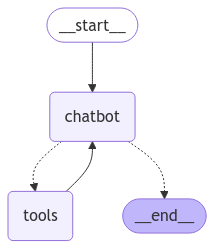

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

In [24]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  你好你是谁？


Assistant: content='你好！我是 Kimi，月之暗面科技有限公司（Moonshot AI）开发的一款人工智能助手。我擅长中英文对话，能够提供安全、有帮助、准确的回答。如果你有任何问题或需要帮助，随时可以问我。' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 88, 'total_tokens': 137, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-c45cb39e-7888-480b-a845-d1538e7f413f-0' usage_metadata={'input_tokens': 88, 'output_tokens': 49, 'total_tokens': 137, 'input_token_details': {}, 'output_token_details': {}}


User:  周深最近的演唱会


Assistant: content='' additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 88, 'total_tokens': 116, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-81cbc16d-26dc-4385-a759-34a96f652f4a-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}] usage_metadata={'input_tokens': 88, 'output_tokens': 28, 'total_tokens': 116, 'input_token_details': {}, 'output_token_details': {}}
Assistant: content='[{"url": "https://baijiahao.baidu.com/s?id=1815659018210283100&wfr=spider&for=pc", "content": "\\u9664\\u4e86\\u4f17\\u6240\\u5468\\u77

User:  周深最近的演唱会是什么时候？


Assistant: content='' additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近演唱会时间"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 91, 'total_tokens': 120, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-93b47350-c6b7-4a3c-af9c-1fac2cd7adfa-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近演唱会时间'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}] usage_metadata={'input_tokens': 91, 'output_tokens': 29, 'total_tokens': 120, 'input_token_details': {}, 'output_token_details': {}}
Assistant: content='[{"url": "https://mbd.baidu.com/newspage/data/dtlandingsuper?nid=dt_4809041755031648712", "content": "\\ud83d\\udcc5 9\\u67087\\u65

User:  q


Goodbye!


## Memory


LangGraph 通过**持久性检查点**解决了这个问题。

如果在编译图表时提供了`checkpoint`，在调用图表时提供了 `thread_id`，LangGraph 会在每一步之后自动保存状态。

当再次使用相同的 `thread_id` 调用图表时，图表会加载其保存的状态，使聊天机器人能够从上次中断的地方继续。

In [25]:
from langgraph.checkpoint.memory import MemorySaver

# 内部是一个defaultdict
memory = MemorySaver()

线上推荐使用 `SqliteSaver`或 `PostgresSaver`。

接下来把`BasicToolNode`替换成内置的`ToolNode` 和 `tools_condition`。

In [27]:
from typing import Annotated

from baiduserp_wapper import BaiduSearchAPIWrapper
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

search = TavilySearchResults(max_results=2)
search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [28]:
graph = graph_builder.compile(checkpointer=memory)

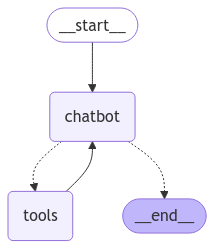

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

首先，选择一个线程作为这次对话的key。

In [35]:
config = {"configurable": {"thread_id": "1"}}

In [36]:
user_input = "你好，我是长琴。"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我是长琴。
================================== Ai Message ==================================

你好，长琴！很高兴再次和你聊天。有什么我可以帮你的吗？


In [37]:
user_input = "记住我的名字了吗？"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

记住我的名字了吗？
================================== Ai Message ==================================

我记得你的名字是长琴。有什么需要我帮忙的吗？


如果我们更换了`thread_id`，会怎么样呢？

In [47]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

记住我的名字了吗？
================================== Ai Message ==================================

当然，我记得你的名字，很高兴再次和你交流！有什么可以帮助你的吗？


我们可以查看`state`。

In [38]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='你好，我是长琴。', additional_kwargs={}, response_metadata={}, id='38b8d596-1254-46a3-a07f-5931c1a1a1f1'), AIMessage(content='你好，长琴！有什么我可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 90, 'total_tokens': 102, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4b0b71aa-bf55-4aeb-810e-36396a4d82b7-0', usage_metadata={'input_tokens': 90, 'output_tokens': 12, 'total_tokens': 102, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='2929319d-dfe7-4261-864d-24efb10f37e6'), AIMessage(content='当然，我记得你的名字是长琴。有什么可以为你服务的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 114, 'total_tokens': 131

In [39]:
snapshot.next

()

Snapshot 包含当前 state values, 相关config, 和下一个要执行的node。

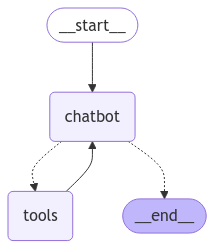

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Human-in-the-Loop


Agent可能不可靠，可能需要人类输入才能成功完成任务。

同样，对于某些操作，我们可能希望在运行之前要求人工确认，以确保一切按照预期运行。

LangGraph 有多种方式支持Human-in-the-Loop。这里使用`interrupt_before` 功能来始终中断工具节点。

In [41]:
from typing import Annotated

from baiduserp_wapper import BaiduSearchAPIWrapper
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

search = TavilySearchResults(max_results=2)
search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [42]:
# 添加一个中断
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [43]:
user_input = "周深最近有演唱会吗，你帮我查查看。"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

周深最近有演唱会吗，你帮我查查看。
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 最近 演唱会


In [44]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [45]:
# 查看rule的请求
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': '周深 最近 演唱会'},
  'id': 'tavily_search_results_json:0',
  'type': 'tool_call'}]

Let's Go Ahead!

In [46]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 最近 演唱会
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://baijiahao.baidu.com/s?id=1815659018210283100&wfr=spider&for=pc", "content": "除了众所周知的顶级唱功外，周深演唱会的另一大法宝就是不计成本地回馈观众。每场都在所有座位上摆放具有城市特色的伴手礼一包，为所有观众准备加厚雨衣、纸巾，每场为观众补贴饮..."}, {"url": "https://www.bilibili.com/video/av113594452679671/", "content": "周深9.29Hz巡回演唱会|深圳场特别回顾 重温雨夜里的蓝海 03:11 周深9.29Hz巡回演唱会|「少管我」LIVE MV上线! 04:34 周深9.29Hz巡回演唱会|成都场特别回顾视频 我们见面的..."}]
================================== Ai Message ==================================

根据搜索结果，周深最近确实有演唱会的活动。他正在进行名为“9.29Hz巡回演唱会”的巡演。不过，具体的演唱会日期和地点需要进一步查找最新的信息。你可以访问周深的官方社交媒体账号或者票务网站获取最新、最准确的演唱会日程安排。


由于我们已经添加了`checkpoint`，因此Graph可以无限期暂停并随时恢复。

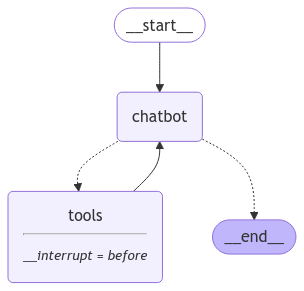

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

## Manually Updating the State

刚刚是中断，现在需要更改中间结果（增加写入逻辑）。

通过修改行动（包括过去的行动）控制轨迹。

In [48]:
from typing import Annotated

from baiduserp_wapper import BaiduSearchAPIWrapper
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

search = TavilySearchResults(max_results=2)
search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

user_input = "周深最近有演唱会吗，你帮我查查看。"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================ Human Message =================================

周深最近有演唱会吗，你帮我查查看。
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:1)
 Call ID: tavily_search_results_json:1
  Args:
    query: 周深 最近 演唱会
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:1)
 Call ID: tavily_search_results_json:1
  Args:
    query: 周深 最近 演唱会


重复上面的代码。

现在我们需要介入，比如让机器人不使用这个工具。

In [49]:
# 我们直接给出正确答案。

from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "周深最近的演唱会在11月10日苏州体育中心体育场举办。"
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()

================================== Ai Message ==================================

周深最近的演唱会在11月10日苏州体育中心体育场举办。


In [50]:
# 然后更新图
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='周深最近的演唱会在11月10日苏州体育中心体育场举办。', id='4a3b8953-2d65-4315-9c9b-8c69e5c7763a', tool_call_id='tavily_search_results_json:1'), AIMessage(content='周深最近的演唱会在11月10日苏州体育中心体育场举办。', additional_kwargs={}, response_metadata={}, id='d073f14b-4935-4176-a854-dce2ad7a540a')]


In [51]:
graph.get_state(config).values["messages"]

[HumanMessage(content='你好，我是长琴。', additional_kwargs={}, response_metadata={}, id='38b8d596-1254-46a3-a07f-5931c1a1a1f1'),
 AIMessage(content='你好，长琴！有什么我可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 90, 'total_tokens': 102, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4b0b71aa-bf55-4aeb-810e-36396a4d82b7-0', usage_metadata={'input_tokens': 90, 'output_tokens': 12, 'total_tokens': 102, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='2929319d-dfe7-4261-864d-24efb10f37e6'),
 AIMessage(content='当然，我记得你的名字是长琴。有什么可以为你服务的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 114, 'total_tokens': 131, 'completion_tokens_details': 

因为我们前面定义`State`时有个`add_messages`，它会将每次的消息append到已有消息列表。

上面的`update_state`执行时是同样的逻辑，`update_state`函数的操作就好像它是图中的一个节点一样。默认情况下，更新操作使用上次执行的节点，但也可以手动指定。


比如，我们添加一个“机器人”消息。

In [52]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbd3f4-ad75-6fcc-8014-364d10ee69ce'}}

In [53]:
graph.get_state(config).values["messages"]

[HumanMessage(content='你好，我是长琴。', additional_kwargs={}, response_metadata={}, id='38b8d596-1254-46a3-a07f-5931c1a1a1f1'),
 AIMessage(content='你好，长琴！有什么我可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 90, 'total_tokens': 102, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4b0b71aa-bf55-4aeb-810e-36396a4d82b7-0', usage_metadata={'input_tokens': 90, 'output_tokens': 12, 'total_tokens': 102, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='2929319d-dfe7-4261-864d-24efb10f37e6'),
 AIMessage(content='当然，我记得你的名字是长琴。有什么可以为你服务的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 114, 'total_tokens': 131, 'completion_tokens_details': 

等于直接走了右边的分支（因为我们将节点更行为`chatbot`）。

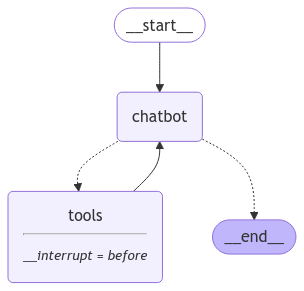

In [54]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [55]:
snapshot = graph.get_state(config)

In [56]:
snapshot.values["messages"][-3:]

[ToolMessage(content='周深最近的演唱会在11月10日苏州体育中心体育场举办。', id='4a3b8953-2d65-4315-9c9b-8c69e5c7763a', tool_call_id='tavily_search_results_json:1'),
 AIMessage(content='周深最近的演唱会在11月10日苏州体育中心体育场举办。', additional_kwargs={}, response_metadata={}, id='d073f14b-4935-4176-a854-dce2ad7a540a'),
 AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='4d5279d6-cd27-44f3-8887-a8ed512c8957')]

In [57]:
# 直接END了
snapshot.next

()

总结一下，此时，我们正扮演机器人，并回复一个不包含工具调用的AIMessage，因此Graph知道它已进入完成状态（下一个为空）。

### Overwrite existing messages


`add_messages`函数控制消息键的更新方式。该函数查看新消息列表中的任何消息ID。如果ID与现有状态中的消息匹配，`add_messages`将使用新内容覆盖现有消息。

举个例子，我们更新工具调用，确保从搜索引擎中获得良好的结果！首先，启动一个新线程：

In [95]:
user_input = "周深最近有演唱会吗，你帮我查查看。"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here

In [102]:
# 这里没有什么消息。
graph.get_state(config).values["messages"]

[HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='8ff0dbfe-d171-4ae8-8d60-466ecdc0a416'),
 AIMessage(content='当然，我记得你的名字，很高兴再次和你交流！有什么可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 89, 'total_tokens': 106, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bbd0cb72-25a3-4893-990b-de9f63c21558-0', usage_metadata={'input_tokens': 89, 'output_tokens': 17, 'total_tokens': 106, 'input_token_details': {}, 'output_token_details': {}})]

In [103]:
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

周深最近有演唱会吗，你帮我查查看。
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 最近 演唱会


In [104]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

Original
Message ID run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0
{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}


In [105]:
existing_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近 演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 125, 'total_tokens': 154, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 125, 'output_tokens': 29, 'total_tokens': 154, 'input_token_details': {}, 'output_token_details': {}})

In [106]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "周深 苏州 演唱会"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

Updated
{'name': 'tavily_search_results_json', 'args': {'query': '周深 苏州 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}
Message ID run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9f0ce-9e45-66ac-8005-40fa9cdf0ded'}}

In [107]:
print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls



Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': '周深 苏州 演唱会'},
  'id': 'tavily_search_results_json:0',
  'type': 'tool_call'}]

In [108]:
# 继续看消息，我们已经成功修改了query
graph.get_state(config).values["messages"]

[HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='8ff0dbfe-d171-4ae8-8d60-466ecdc0a416'),
 AIMessage(content='当然，我记得你的名字，很高兴再次和你交流！有什么可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 89, 'total_tokens': 106, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bbd0cb72-25a3-4893-990b-de9f63c21558-0', usage_metadata={'input_tokens': 89, 'output_tokens': 17, 'total_tokens': 106, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='8627f57f-1bd5-41d0-8b47-3813e0dc6e34'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 苏州 演唱会

通过使用空输入和现有配置来恢复Graph的流式处理。

In [109]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 苏州 演唱会
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://m.163.com/dy/article/JDTHUVGG05564Y22.html", "content": "在本场巡演中,周深致力为广大歌迷呈现无与伦比的视听盛宴,因此将通过LED屏幕与灯光层次分明的置景运用、特效VCR以及质感有力量的群舞表演等方面去实现,丰富的音乐表达,极佳的现场观..."}, {"url": "https://3g.163.com/news/article/JGFPAD9204249CU3.html", "content": "周深「9.29Hz」2024十周年巡回演唱会-苏州站 将在苏州体育中心体育场举办 这份观演和出行指南 赶紧收好~ 打开网易新闻 查看精彩图片 像微风拂过夜空 像海豚在深海高歌 9.29Hz..."}]
================================== Ai Message ==================================

周深最近有一场演唱会，名为“周深「9.29Hz」2024十周年巡回演唱会”，苏州站将于2024年在苏州体育中心体育场举行。这场巡演周深将为广大歌迷呈现无与伦比的视听盛宴，通过LED屏幕、灯光置景、特效VCR以及群舞表演等方面丰富音乐表达和提升现场观感。


In [110]:
# 查看消息
graph.get_state(config).values["messages"]

[HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='8ff0dbfe-d171-4ae8-8d60-466ecdc0a416'),
 AIMessage(content='当然，我记得你的名字，很高兴再次和你交流！有什么可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 89, 'total_tokens': 106, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bbd0cb72-25a3-4893-990b-de9f63c21558-0', usage_metadata={'input_tokens': 89, 'output_tokens': 17, 'total_tokens': 106, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='8627f57f-1bd5-41d0-8b47-3813e0dc6e34'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 苏州 演唱会

所有刚刚的改动都反映在Graph的checkpoint中，这意味着如果我们继续对话，它将会记住所有修改过的状态。

In [111]:
events = graph.stream(
    {
        "messages": (
            "user",
            "记住我刚刚查询的内容了吗？",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

记住我刚刚查询的内容了吗？
================================== Ai Message ==================================

是的，我记得你刚刚查询了周深最近的演唱会信息。如果你还有其他关于周深演唱会的问题或者需要进一步的帮助，请随时告诉我！


In [112]:
graph.get_state(config).values["messages"]

[HumanMessage(content='记住我的名字了吗？', additional_kwargs={}, response_metadata={}, id='8ff0dbfe-d171-4ae8-8d60-466ecdc0a416'),
 AIMessage(content='当然，我记得你的名字，很高兴再次和你交流！有什么可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 89, 'total_tokens': 106, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bbd0cb72-25a3-4893-990b-de9f63c21558-0', usage_metadata={'input_tokens': 89, 'output_tokens': 17, 'total_tokens': 106, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='8627f57f-1bd5-41d0-8b47-3813e0dc6e34'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-0e0dea77-1456-443a-ae7e-50101ddf4a44-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 苏州 演唱会

结合 `interrupt_before` 和 u`pdate_state`，可以在人机协作工作流程中手动修改状态。中断和状态修改可以让控制Agent的行为。结合持久化的`checkpoint`记录，这意味着我们可以暂停一个动作，并在任何时候恢复。当Graph中断时，用户不必在场！


关键：
- 如果要在某个节点暂停，要添加 `.compile(..., interrupt_before=[...])`（或 `interrupt_after`）。
- 然后使用 `update_state` 修改`checkpoint`并控制Graph应该如何继续。

## Customizing State


目前的State比较简单（一个列表的消息），但如果你想定义复杂行为而不依赖消息列表，可以向状态添加额外的字段。

上面的例子中，我们以确定性的方式让人参与进来：每当调用工具时，Graph总是会中断。假设我们希望我们的聊天机器人可以选择是否依赖人类。

一种方法是在一个称为“human”的节点之前创建一个透传节点，Graph在这之前总是会停止。如果LLM调用了一个“human”工具，我们才执行节点。

In [58]:
from typing import Annotated

from baiduserp_wapper import BaiduSearchAPIWrapper
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

接下来，定义一个Schema来显示模型，让它决定是否请求帮助。

In [59]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.


    将对话上报给专家。如果您无法直接提供帮助，或者用户需要超出您权限的支持，请使用此选项。
    要使用此功能，请转发用户的“请求”，以便专家提供正确的指导。
    """

    request: str

接下来，定义 Chatbot 节点。此处的主要修改是，如果我们看到聊天机器人已调用 `RequestAssistance` 标志，则`ask_human=True`。

In [60]:
search = TavilySearchResults(max_results=2)
search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

接下来，创建Graph Builder，并将 chatbot 和 tools 节点添加到Graph中，和前面一样。

In [61]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

接下来创建`human`节点（节点创建完再处理边），它就是个占位符，触发中断。

- 如果中断期间，用户啥也没干，它会插入一条tool消息，以便让LLM知道用户被请求了但是没有响应。
- 此节点还会设置`as_human=False`，以便LLM知道除非有下一个请求，否则不会重复访问该节点。

In [63]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    # 如果中断后啥也没干，那最后一条是AIMessage（上面的例子是提取的query）
    # 此时手动创建一条ToolMessage
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    # 一般用户会在中断期间更新状态（就像前面的操作）
    # 此时，倒数第二条消息是AIMessage（上面的例子是改写后的query）
    # 最后一条消息则是ToolMessage（根据改写后query查询的结果）
    else:
        ...
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

接下来定义条件逻辑，如果flag=True，`select_next_node`将路由到`human`节点，否则让`tools_condition`选择下一个节点。

`tools_condition` 函数只是检查聊天机器人是否在其响应消息中响应了任何tool_calls。如果是这样，它将路由到 `action` 节点。否则结束。

In [64]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [66]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


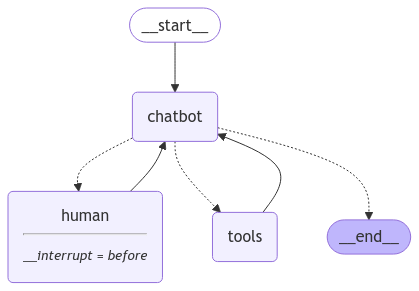

In [67]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [68]:
user_input = "我需要人来帮我确认周深苏州演唱会时间，你能帮我发起请求吗？"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

我需要人来帮我确认周深苏州演唱会时间，你能帮我发起请求吗？
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (RequestAssistance:0)
 Call ID: RequestAssistance:0
  Args:
    request: 请协助确认周深苏州演唱会的具体时间


In [69]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

Graph状态确实在 `human` 节点之前被中断。我们可以添加新的 `ToolMessage` 来手动更新状态。

- 1. 创建 `ToolMessage`，这将传递回聊天机器人。
- 2. 调用 `update_state` 手动更新图形状态。

In [70]:
snapshot.values["messages"]

[HumanMessage(content='我需要人来帮我确认周深苏州演唱会时间，你能帮我发起请求吗？', additional_kwargs={}, response_metadata={}, id='ae9e917d-fb79-4f1d-b24c-af6fe9bfe7d4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'RequestAssistance:0', 'function': {'arguments': '{\n  "request": "请协助确认周深苏州演唱会的具体时间"\n}', 'name': 'RequestAssistance'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 220, 'total_tokens': 249, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f112bd2-7be2-4502-bfe0-f820cc3b0730-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': '请协助确认周深苏州演唱会的具体时间'}, 'id': 'RequestAssistance:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 29, 'total_tokens': 249, 'input_token_details': {}, 'output_token_details': {}})]

In [71]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "周深苏州演唱会的时间是11月10日晚上7点。"
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbd40b-2021-690c-8002-91e2db3ba05d'}}

In [72]:
# 我们手动添加了ToolMessage
graph.get_state(config).values["messages"]

[HumanMessage(content='我需要人来帮我确认周深苏州演唱会时间，你能帮我发起请求吗？', additional_kwargs={}, response_metadata={}, id='ae9e917d-fb79-4f1d-b24c-af6fe9bfe7d4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'RequestAssistance:0', 'function': {'arguments': '{\n  "request": "请协助确认周深苏州演唱会的具体时间"\n}', 'name': 'RequestAssistance'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 220, 'total_tokens': 249, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f112bd2-7be2-4502-bfe0-f820cc3b0730-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': '请协助确认周深苏州演唱会的具体时间'}, 'id': 'RequestAssistance:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 29, 'total_tokens': 249, 'input_token_details': {}, 'output_token_details': {}}),
 ToolMessage(cont

## Time Travel


在典型的聊天机器人工作流程中，用户与机器人交互 1 次或多次以完成任务。

但是，如果想让用户从之前的响应开始，然后 “分支” 以探索其他结果，该怎么办？

或者，如果希望用户能够 “回退” 助手的工作以修复一些错误或尝试不同的策略，该怎么办？


接下来，我们将通过使用Graph的 `get_state_history` 方法获取checkpoint来“回退”Graph。然后，可以这个时间点恢复执行。

In [73]:
from typing import Annotated
from pydantic import BaseModel

from baiduserp_wapper import BaiduSearchAPIWrapper
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, ToolMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition



class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.


    将对话上报给专家。如果您无法直接提供帮助，或者用户需要超出您权限的支持，请使用此选项。
    要使用此功能，请转发用户的“请求”，以便专家提供正确的指导。
    """

    request: str


search = TavilySearchResults(max_results=2)
search.api_wrapper = BaiduSearchAPIWrapper(max_results=search.max_results)
tools = [search]

llm = ChatOpenAI(
    model="moonshot-v1-128k", 
    base_url="https://api.moonshot.cn/v1", 
)
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)



def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    # 如果中断后啥也没干，那最后一条是AIMessage（上面的例子是提取的query）
    # 此时手动创建一条ToolMessage
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    # 一般用户会在中断期间更新状态（就像前面的操作）
    # 此时，倒数第二条消息是AIMessage（上面的例子是改写后的query）
    # 最后一条消息则是ToolMessage（根据改写后query查询的结果）
    else:
        ...
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

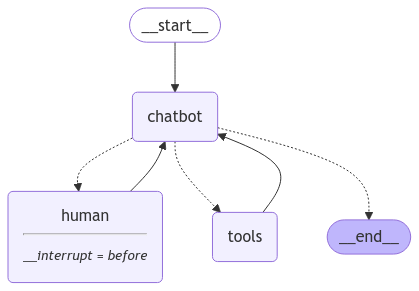

In [74]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [75]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "周深最近有演唱会吗，你帮我查查看。")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

周深最近有演唱会吗，你帮我查查看。
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 最近 演唱会
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.bilibili.com/video/av113594452679671/", "content": "周深9.29Hz巡回演唱会|深圳场特别回顾 重温雨夜里的蓝海 03:11 周深9.29Hz巡回演唱会|「少管我」LIVE MV上线! 04:34 周深9.29Hz巡回演唱会|成都场特别回顾视频 我们见面的..."}, {"url": "https://www.douyin.com/topic/7273271379704383551", "content": "您在查找周深2024年演唱会地点及时间吗?抖音短视频帮您找到更多精彩的视频内容!让每一个人看见并连接更大的世界,让现实生活更美好"}]
================================== Ai Message ==================================

周深最近有在2024年举办的9.29Hz巡回演唱会。根据搜索结果，可以看到有关于深圳场和成都场特别回顾的视频，以及“少管我”LIVE MV上线的相关信息。如果您想了解更多详情，可以访问相关网站或社交平台查找最新的演唱会信息。


In [76]:
graph.get_state(config).values["messages"]

[HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='52d362ff-fe44-4f97-a633-22ad8a66d4d3'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近 演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 214, 'total_tokens': 243, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-729e3b21-e7a2-41ee-bc03-18a6ee7ac3d9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 29, 'total_tokens': 243, 'input_token_details': {}, 'output_token_details': {}}),
 ToolMessage(

In [77]:
events = graph.stream(
    {
        "messages": [
            ("user", "好，现在能帮我查查他在苏州有演唱会吗")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

好，现在能帮我查查他在苏州有演唱会吗
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 苏州 演唱会
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://mp.weixin.qq.com/s?__biz=MzAxNTQxNTMwMA==&mid=2651247165&idx=1&sn=4c89293c685732a7fb4ce01cd4366de3&chksm=81337dec5298314eaf379bbeb6ea8c706839caa28748902330cc30ad2f5d7f4251c776fab33a&scene=27", "content": "周深演唱会要来啦 2024周深9.29Hz巡回演唱会 苏州站 时间:2024年11月9日-11月10日(周六-周日)19:00 地点:苏州市体育中心体育场(江苏省苏州市姑苏区三香路1131号) 姑苏 承载着深厚的..."}, {"url": "https://mbd.baidu.com/newspage/data/dtlandingsuper?nid=dt_4751324988108572806", "content": "苏州的夜晚,周深的演唱会如同一场绚烂的梦境。对于第一次现场观看专业歌手的我来说,这无疑是一次震撼的体验。周深的现场表现,远比我在耳机里听到的要震撼得多。在演唱会之前,我特..."}]
==================================

我们已经执行了2个步骤，现在可以重放完整的状态历史记录以查看发生的所有内容。

In [78]:
graph.get_state(config).values["messages"]

[HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='52d362ff-fe44-4f97-a633-22ad8a66d4d3'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近 演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 214, 'total_tokens': 243, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-729e3b21-e7a2-41ee-bc03-18a6ee7ac3d9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 29, 'total_tokens': 243, 'input_token_details': {}, 'output_token_details': {}}),
 ToolMessage(

In [160]:
len(_)

8

In [80]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [81]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbd418-13b2-6b14-8006-fb02bd2e7b99'}}


`checkpoint`的配置 （`to_replay.config`） 包含`checkpoint_id`时间戳。提供这个 `checkpoint_id` 值告诉 LangGraph 的 `checkpointer` 从该时刻开始加载状态。

In [82]:
to_replay.values["messages"]

[HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='52d362ff-fe44-4f97-a633-22ad8a66d4d3'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近 演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 214, 'total_tokens': 243, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-729e3b21-e7a2-41ee-bc03-18a6ee7ac3d9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 29, 'total_tokens': 243, 'input_token_details': {}, 'output_token_details': {}}),
 ToolMessage(

In [83]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tavily_search_results_json:0)
 Call ID: tavily_search_results_json:0
  Args:
    query: 周深 苏州 演唱会
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://mp.weixin.qq.com/s?__biz=MzAxNTQxNTMwMA==&mid=2651247165&idx=1&sn=4c89293c685732a7fb4ce01cd4366de3&chksm=81337dec5298314eaf379bbeb6ea8c706839caa28748902330cc30ad2f5d7f4251c776fab33a&scene=27", "content": "周深演唱会要来啦 2024周深9.29Hz巡回演唱会 苏州站 时间:2024年11月9日-11月10日(周六-周日)19:00 地点:苏州市体育中心体育场(江苏省苏州市姑苏区三香路1131号) 姑苏 承载着深厚的..."}, {"url": "https://mbd.baidu.com/newspage/data/dtlandingsuper?nid=dt_4751324988108572806", "content": "苏州的夜晚,周深的演唱会如同一场绚烂的梦境。对于第一次现场观看专业歌手的我来说,这无疑是一次震撼的体验。周深的现场表现,远比我在耳机里听到的要震撼得多。在演唱会之前,我特..."}]
================================== Ai Message ==================================

周深确实在苏州有演唱会，这是他2024年9.29Hz巡回演唱会的一部分。具体信息如下：

- 时间：202

Graph从 **action** 节点恢复了执行。可以看出情况确实如此，因为上面打印的第一个值是来自我们的搜索引擎工具的响应。

In [84]:
graph.get_state(config).values

{'messages': [HumanMessage(content='周深最近有演唱会吗，你帮我查查看。', additional_kwargs={}, response_metadata={}, id='52d362ff-fe44-4f97-a633-22ad8a66d4d3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json:0', 'function': {'arguments': '{\n  "query": "周深 最近 演唱会"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 214, 'total_tokens': 243, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-128k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-729e3b21-e7a2-41ee-bc03-18a6ee7ac3d9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '周深 最近 演唱会'}, 'id': 'tavily_search_results_json:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 29, 'total_tokens': 243, 'input_token_details': {}, 'output_token_details': {}}),

In [174]:
len(graph.get_state(config).values["messages"])

8

## Homework

- 请参考[LangGraph Example](https://langchain-ai.github.io/langgraph/#example)重写tool。
- 请使用多个tool。

## Reference

- https://langchain-ai.github.io/langgraph/tutorials/introduction/